## Introduction
I'm going to begin a multipart series of posts on Reinforcement Learning (RL) that roughly follow an old 1996 textbook "Reinforcement Learning An Introduction" by Sutton and Barto. From my research, this text still seems to be the most thorough introduction to RL I could find. The Barto & Sutton text is itself a great read and is fairly approachable even for beginners, but I still think it's worth breaking down even further. It still amazes me how most of machine learning theory was established decades ago yet we've seen a huge explosion of interest and use in just the past several years largely due to dramatic improvements in computational power (i.e. GPUs) and the availibility of massive data sets ("big data"). The first implementations of neural networks date back to the early 1950s!

While really neat results have been achieved using supervised learning models (e.g. Google's DeepDream), many consider reinforcement learning to be the holy grail of machine learning. If we can build a general learning algorithm that can learn patterns and make predictions with unlabeled data, that would be a game-changer. Google DeepMind's Deep Q-learning algorithm that learned to play dozens of old Atari games with just the raw pixel data and the score is a big step in the right direction. Clearly, there is much to be done. The algorithm still struggles with long timespan rewards (i.e. taking actions that don't result in reward for a relatively long period of time), which is why it failed to learn how to play Montezuma's Revenge and similar games. Q-learning is something that was first described in 1989, and while DeepMind's specific implementation had some novelties, it's largely the same algorithm from way back then.

In this series, I will be covering major topics and algorithms in RL mostly from the Barto & Sutton text, but I will also include more recent advances and material where appropriate. My goal (as with all my posts) is to help those with limited mathematical backgrounds to grasp the concepts and be able to translate the equations into code (I'll use Python here). As a heads-up, the code presented here will (hopefully) maximize for readability and understandability often at the expense of computational efficiency and quality. I.e. my code will not be production-quality and is just for enhanced learning. My only assumumptions for this series is that you're proficient with Python and Numpy and have at least some basic knowledge of linear algebra and statistics/probability.

## n-armed bandit problem
We're going to build our way up from very simple RL algorithms to much more sophisticated ones that could be used to learn to play games, for example. The theory and math builds on each preceding part, so I strongly recommend you follow this series in order even though the first parts are less exciting.

Let's consider a hypothetical problem where we're at a casino and in a section with some slot machines. Let's say we're at a section with 10 slot machines in a row and it says "Play for free! Max payout is $10!" Wow, not bad right! Let's say we ask one of the employees what's going on here, it seems too good to be true, and she says "It's really true, play as much as you want, it's free. Each slot machine is gauranteed to give you a reward between 0 and $10. Oh, by the way, keep this on the down low but those 10 slot machines each have a different average payout, so try to figure out which one gives out the most rewards on average and you'll be making tons of cash!"

What kind of casino is this?! Who knows, but it's awesome. Oh by the way, here's a joke: What's another name for a slot machine? .... A one-armed bandit! Get it? It's got one arm (a lever) and it generally steals your money! Huh, well I guess we could call our situation a 10-armed bandit problem, or an n-armed bandit problem more generally, where n is the number of slot machines.

Let me restate our problem more formally. We have n possible actions (here n = 10) and at each play (k) of this "game" we can choose a single lever to pull. After taking an action aa we will receive a reward RkRk (reward at play k). Each lever has a unique probability distribution of payouts (rewards). For example, if we have 10 slot machines, slot machine #3 may give out an average reward of $9 whereas slot machine \#1 only gives out an average reward of $4. Of course, since the reward at each play is probabilistic, it is possible that lever #1 will by chance give us a reward of $9 on a single play. But if we play many games, we expect on average slot machine #1 is associated with a lower reward than #3.

Thus in words, our strategy should be to play a few times, choosing different levers and observing our rewards for each action. Then we want to only choose the lever with the largest observed average reward. Thus we need a concept of expected reward for taking an action aa based on our previous plays, we'll call this expected reward Qk(a)Qk(a) mathematically. Qk(a)Qk(a) is a function that accepts action aa and returns the expected reward for that action. Formally,
Qk(a)=R1+R2+...+Rkka
Qk(a)=R1+R2+...+Rkka
That is, the expected reward at play k for action aa is the arithmetic mean of all the previous rewards we've received for taking action a. Thus our previous actions and observations influence our future actions, we might even say some of our previous actions reinforce our current and future actions. We'll come back to this later.

Some keywords for this problem are exploration and exploitation. Our strategy needs to include some amount of exploitation (simply choosing the best lever based on what we know so far) and some amount of exploration (choosing random levers so we can learn more). The proper balance of exploitation and exploration will be important to maximizing our rewards.

So how can we come up with an algorithm to figure out which slot machine has the largest average payout? Well, the simplest algorithm would be to select action aa for which this equation is true:
Qk(Ak)=maxa(Qk(a))
Qk(Ak)=maxa(Qk(a))
This equation/rule states that the expected reward for the current play k for taking action AA is equal to the maximum average reward of all previous actions taken. In other words, we use our above reward function Qk(a)Qk(a) on all the possible actions and select the one that returns the maximum average reward. Since Qk(a)Qk(a) depends on a record of our previous actions and their associated rewards, this method will not select actions that we haven't already explored. Thus we might have previously tried lever 1 and lever 3, and noticed that lever 3 gives us a higher reward, but with this method, we'll never think to try another lever, say #6, which, unbeknownst to us, actually gives out the highest average reward. This method of simply choosing the best lever that we know of so far is called a "greedy" method.

Obviously, we need to have some exploration of other levers (slot machines) going on to discover the true best action. One simple modification to our above algorithm is to change it to an ϵϵ (epsilon)-greedy algorithm, such that, with a probability ϵϵ, we will choose an action aa at random, and the rest of the time (probability 1−ϵ1−ϵ) we will choose the best lever based on what we currently know from past plays. So most of the time we play greedy, but sometimes we take some risks and choose a random lever and see what happens. This will of course influence our future greedy actions.

Alright, I think that's an in-depth enough discussion of the problem and how we want to try to solve it with a rudimentary RL algorithm. Let's start implementing this with Python.

In [11]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
n = 10
arms = np.random.rand(n)
eps = 0.1
arms

array([ 0.2019979 ,  0.74323749,  0.04800093,  0.75121935,  0.78096509,
        0.19047569,  0.91907521,  0.75620584,  0.1137517 ,  0.2282248 ])

Per our casino example, we will be solving a 10-armed bandit problem, hence n = 10. I've also defined a numpy array of length n filled with random floats that can be understood as probabilities. The way I've chosen to implement our reward probability distributions for each arm/lever/slot machine is this: Each arm will have a probability, e.g. 0.7. The maximum reward is $10. We will setup a for loop to 10 and at each step, it will add +1 to the reward if a random float is less than the arm's probability. Thus on the first loop, it makes up a random float (e.g. 0.4). 0.4 is less than 0.7, so reward += 1. On the next iteration, it makes up another random float (e.g. 0.6) which is also less than 0.7, thus reward += 1. This continues until we complete 10 iterations and then we return the final total reward, which could be anything 0 to 10. With an arm probability of 0.7, the average reward of doing this to infinity would be 7, but on any single play, it could be more or less.

In [48]:
def reward(prob):
    reward = 0
    for i in range(10):
        if random.random() < prob:
            reward += 1
    return reward

The next function we define is our greedy strategy of choosing the best arm so far. This function will accept a memory array that stores in a key-value sort of way the history of all actions and their rewards. It is a 2 x k2 x k matrix where each row is an index reference to our arms array (1st element) and the reward received (2nd element). For example, if a row in our memory array is [2, 8] it means that action 2 was taken (the 3rd element in our arms array) and we received a reward of 8 for taking that action.

In [49]:
#initialize memory array; has 1 row defaulted to random action index
av = np.array([np.random.randint(0, (n+1)), 0]).reshape(1, 2)
print(av)
#greedy method to select best arm based on memory array (historical results)
def bestArm(a):
    bestArm = 0
    bestMean = 0
    for u in a:
        avg = np.mean(a[np.where(a[:, 0] == u[0])][: 1])
        if bestMean < avg:
            bestMean = avg
            bestArm = u[0]
    return bestArm

[[0 0]]


And here is the main loop for each play. I've set it to play 500 times and display a matplotlib scatter plot of the mean reward against plays. Hopefully we'll see that the mean reward increases as we play more times.

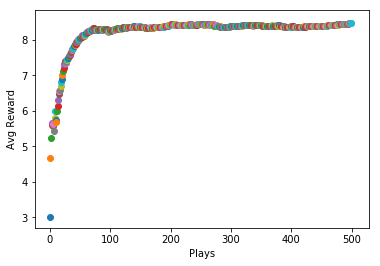

In [50]:
plt.xlabel("Plays")
plt.ylabel("Avg Reward")
for i in range(500):
    if random.random() > eps: #greedy arm selection
        choice = bestArm(av)
        thisAV = np.array([[choice, reward(arms[choice])]])
        av = np.concatenate((av, thisAV), axis=0)
    else: #random arm selection
        choice = np.where(arms == np.random.choice(arms))[0][0]
        thisAV = np.array([[choice, reward(arms[choice])]]) #choice, reward 
        av = np.concatenate((av, thisAV), axis=0) #add to our action-value memory array
    #calculate the percentage the correct arm is chosen (you can plot this instead of reward)
    percCorrect = 100*(len(av[np.where(av[:,0] == np.argmax(arms))])/len(av))
    #calculate the mean reward
    runningMean = np.mean(av[:,1])
    plt.scatter(i, runningMean)

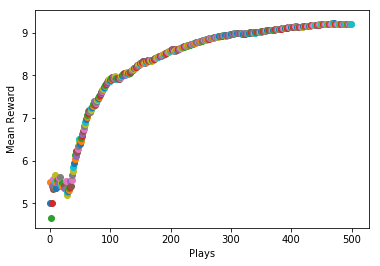

In [51]:
n = 10
arms = np.random.rand(n)
eps = 0.1

av = np.ones(n) #initialize action-value array
counts = np.zeros(n) #stores counts of how many times we've taken a particular action

def reward(prob):
    total = 0;
    for i in range(10):
        if random.random() < prob:
            total += 1
    return total

#our bestArm function is much simpler now
def bestArm(a):
    return np.argmax(a) #returns index of element with greatest value
    
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
for i in range(500):
    if random.random() > eps:
        choice = bestArm(av)
        counts[choice] += 1
        k = counts[choice]
        rwd =  reward(arms[choice])
        old_avg = av[choice]
        new_avg = old_avg + (1/k)*(rwd - old_avg) #update running avg
        av[choice] = new_avg
    else:
        choice = np.where(arms == np.random.choice(arms))[0][0] #randomly choose an arm (returns index)
        counts[choice] += 1
        k = counts[choice]
        rwd =  reward(arms[choice])
        old_avg = av[choice]
        new_avg = old_avg + (1/k)*(rwd - old_avg) #update running avg
        av[choice] = new_avg
    #have to use np.average and supply the weights to get a weighted average
    runningMean = np.average(av, weights=np.array([counts[j]/np.sum(counts) for j in range(len(counts))]))
    plt.scatter(i, runningMean)

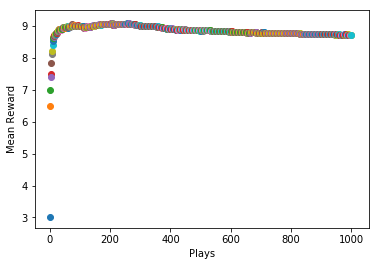

In [64]:
n = 10
arms = np.random.rand(n)

av = np.ones(n) #initialize action-value array, stores running reward mean
counts = np.zeros(n) #stores counts of how many times we've taken a particular action
#stores our softmax-generated probability ranks for each action
av_softmax = np.zeros(n)
av_softmax[:] = 0.1 #initialize each action to have equal probability

def reward(prob):
    total = 0;
    for i in range(10):
        if random.random() < prob:
            total += 1
    return total

tau = 1.12 #tau was selected by trial and error
def softmax(av):
    probs = np.zeros(n)
    for i in range(n):
        softm = ( np.exp(av[i] / tau) / np.sum( np.exp(av[:] / tau) ) )
        probs[i] = softm
    return probs

plt.xlabel("Plays")
plt.ylabel("Mean Reward")
for i in range(1000):
    #select random arm using weighted probability distribution
    choice = np.where(arms == np.random.choice(arms, p=av_softmax))[0][0]
    counts[choice] += 1
    k = counts[choice]
    rwd =  reward(arms[choice])
    old_avg = av[choice]
    new_avg = old_avg + (1/k)*(rwd - old_avg)
    av[choice] = new_avg
    av_softmax = softmax(av) #update softmax probabilities for next play
        
    runningMean = np.average(av, weights=np.array([counts[j]/np.sum(counts) for j in range(len(counts))]))
    plt.scatter(i, runningMean)